In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx, get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calculate_precision, calculate_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

In [2]:
# available for test:
# 20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323
# 1921, 1911, 1899, 1831, 1826, 1813, 1808, 704, 702, 635, 628, 626, 615, 593,
# 456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 231, 200, 158, 150, 
# 126, 119, 118, 117, 116, 115, 114, 113

# available for experiments:
# 114, 115, 116, 117, 119, 302, 303, 304, 305, 306, 307,
# 308, 309, 393, 442, 470, 471, 472, 502, 503, 504, 505,
# 506, 507, 508, 511, 512, 513, 514, 515, 516, 591, 592,
# 593, 596, 597, 599, 612, 613, 614, 615, 616, 617, 618,
# 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629,
# 836, 837, 838, 839, 862, 863, 874, 875, 888, 1820, 1832,
# 1833, 1834, 1835, 1836, 1838, 1896, 1899, 4007

# small outliers:
# 114, 119, 302, 303, 442, 511, 512, 514, 629, 838, 839

# big bugs
# 307, 393, 503, 504, 505, 516, 619, 1838, 1896 -- big bugs

## Loading data

In [3]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
                   #[20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323, 
                   #1921, 1911, 1899, 1831, 1826, 1813, 1808, 704, 702, 635,
                   #628, 626, 615, 593, 456, 454, 435, 432, 411, 401, 
                   #309, 308, 305, 302, 239, 228, 223, 200, 152, 150,
                   #126, 119, 118, 117, 116, 115, 114, 113]


train_station_id = [456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 200, 152, 150, 
                    126, 119, 118, 117, 116, 115, 114, 113, 1820,
                    20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323,
                    628, 626, 615, 593, 456, 454, 435, 432, 411, 401] 
#                    613, 614, 616, 617, 618, 619, 620, 621, 622, 623, 
#                    624, 625, 627, 629, 836, 837, 838, 839, 862, 863, 
#                    874, 875, 888, 1820, 1832, 1833, 1834, 1835, 1836, 
#                    1838, 1896, 4007]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 45s, sys: 12.1 s, total: 1min 57s
Wall time: 1min 57s


## Add labels to test

In [31]:
test['label_true'] = get_labels(test, labels_type='true')
#test['label_true'] = np.random.binomial(1, 0.05, len(test))
#test['label_predict'] = np.random.binomial(1, 0.2, len(test))

## Calculate Precision

In [ ]:
precision = calculate_precision(test)
recall = calculate_recall(test)
print(precision, recall)

## Clean data

In [6]:
train = get_clean_data(train)

## Feature selection

In [42]:
%%time

import xgboost as xgb
from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

df_train = create_feature_df(train[train['date_time_utc'] < point])
df_valid = create_feature_df(train[train['date_time_utc'] >= point])
df_test = create_feature_df(test)

features = [col for col in df_train if col.startswith('data_')]
target = [col for col in df_train if col.startswith('target_')][0]

X_train = np.array(df_train[features].values)
y_train = np.array(df_train[target].values.reshape(-1, 1))

X_valid = np.array(df_valid[features].values)
y_valid = np.array(df_valid[target].values.reshape(-1, 1))

X_test = np.array(df_test[features].values)
y_test = np.array(df_test[target].values.reshape(-1, 1))

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_valid, y_valid)
dtest = xgb.DMatrix(X_test, y_test)

CPU times: user 8.1 s, sys: 2.77 s, total: 10.9 s
Wall time: 11 s


In [28]:
#from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from functools import partial

params = {}

params["eval_metric"] = 'mae'
params["eta"] = 0.1
params["lambda"] = 1.
#params["alpha"] = 1.0
params["subsample"] = 0.9
#params["min_child_weight"] = 1.
params["colsample_bytree"] = 0.9
params["max_depth"] = 7
params["silent"] = 1
params["gamma"] = 0.1
delta = 1.
watchlist = [(dtrain, 'train'), (dval, 'valid')]

clf = xgb.train(params, dtrain, 200, watchlist, verbose_eval=20)

[0]	train-mae:6.75922	valid-mae:6.75261
[20]	train-mae:0.940096	valid-mae:0.928302
[40]	train-mae:0.380067	valid-mae:0.382304
[60]	train-mae:0.344972	valid-mae:0.357759
[80]	train-mae:0.337546	valid-mae:0.358211
[100]	train-mae:0.333335	valid-mae:0.35669
[120]	train-mae:0.330044	valid-mae:0.35561
[140]	train-mae:0.32748	valid-mae:0.354994
[160]	train-mae:0.325039	valid-mae:0.35489
[180]	train-mae:0.32296	valid-mae:0.355886
[199]	train-mae:0.321171	valid-mae:0.355577


In [52]:
from sklearn.metrics import mean_absolute_error

y_true = dtest.get_label()
y_pred = clf.predict(dtest).ravel()

print(mean_absolute_error(y_true, y_pred))
upper = y_pred + 0.48 * 10
lower = y_pred - 0.48 * 10
df_test['label_predict'] = ((y_true > upper) | (y_true < lower))

0.3551597


In [53]:
%%time
calculate_precision(df_test)

CPU times: user 5min 56s, sys: 485 ms, total: 5min 56s
Wall time: 5min 59s


1.0

In [58]:
calculate_recall(df_test)

0.006649850951616602

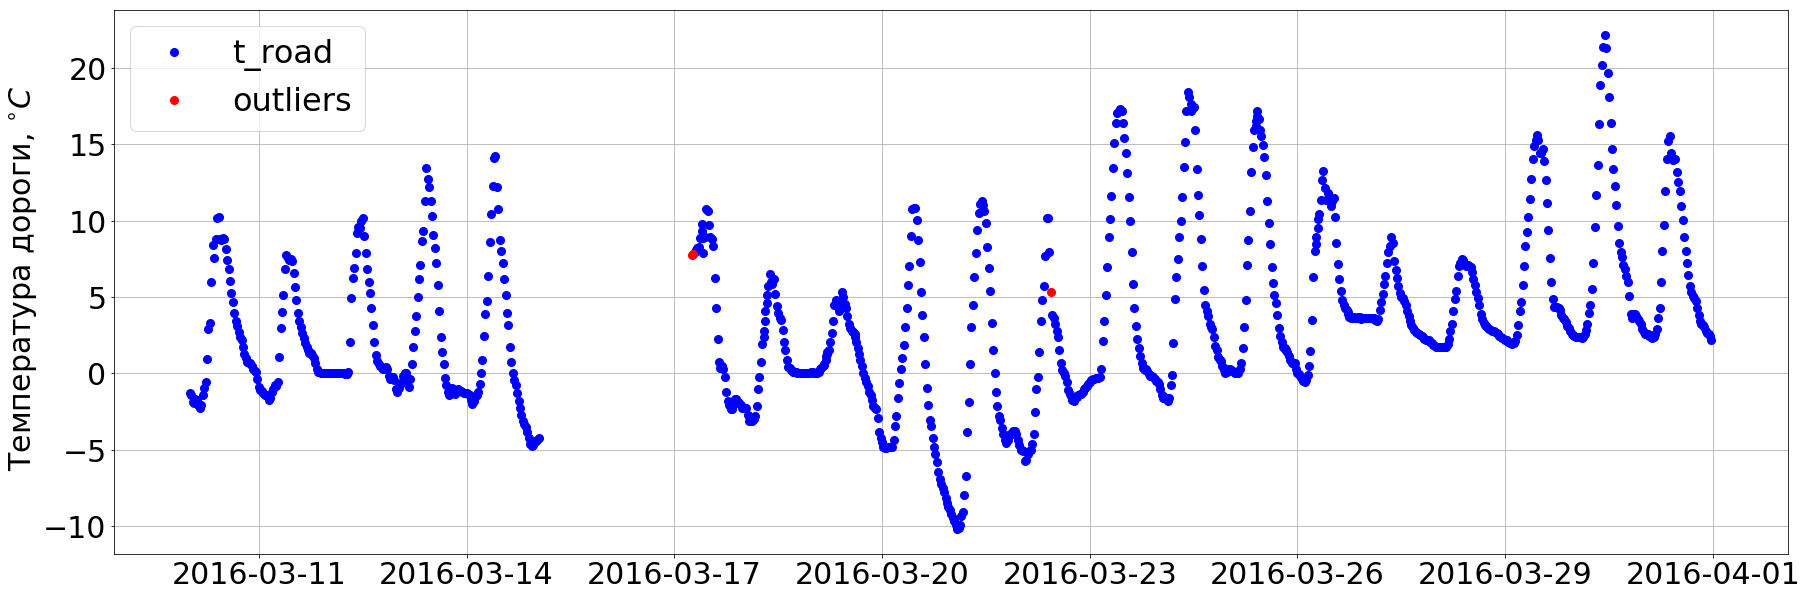

In [57]:
import matplotlib.pyplot as plt


#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==119].set_index('date_time_utc'))

start = pd.Timestamp(2016, 3, 10)
end = pd.Timestamp(2016, 4, 10)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond = (to_plot['label_predict'] == 0) == elem
    if elem:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)
plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()